<a href="https://colab.research.google.com/github/sahinya17/ANN-Electricity-data/blob/main/ETC5555_ElectricityData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [8]:
%%R
# install.packages("keras")
# install.packages("tensorflow")
# library(tensorflow)
# install_tensorflow(method = "auto")

# library(keras)
# install_keras(method = c("conda"), conda = "auto", tensorflow = "default",
#               extra_packages = c("tensorflow-hub"))

# install.packages("tidyverse")
# install.packages("DataExplorer")
# install.packages("caret")

NULL


In [9]:
%%R
library(tidyverse)
library(DataExplorer)
library(tensorflow)
library(keras)
library(caret)

In [10]:
%%R

data <- read.csv("Electricity_data_Poland.csv") %>% select(!X)

nnet_data <- data %>% 
  separate(time, into = c("time_from", "time_to"), sep = " - ") %>% 
  mutate(time_from = as.factor(time_from),
         Date = as.Date(Date, format = "%d-%m-%Y"),
         totalLoad = as.numeric(totalLoad))
  
nnet_data[rowSums(is.na(nnet_data)) > 0,"totalLoad"] <- nnet_data[(which(is.na(nnet_data), arr.ind=TRUE)[1,1])-1,"totalLoad"]

In [11]:
%%R
nnet_data <- data.matrix(nnet_data[,'totalLoad'])

train_data <- nnet_data[1:30000,]
mean <- mean(train_data)
std <- sd(train_data)
nnet_data <- scale(nnet_data, center = mean, scale = std)

In [12]:
%%R
generator <- function(data, lookback, delay, min_index, max_index,
                      shuffle = FALSE, batch_size = 128, step = 1) {
  if (is.null(max_index))
    max_index <- nrow(data) - delay - 1
  i <- min_index + lookback
  function() {
    if (shuffle) {
      rows <- sample(c((min_index+lookback):max_index), size = batch_size)
    } else {
      if (i + batch_size >= max_index)
        i <<- min_index + lookback
      rows <- c(i:min(i+batch_size-1, max_index))
      i <<- i + length(rows)
    }

    samples <- array(0, dim = c(length(rows),
                                lookback / step,
                                dim(data)[[-1]]))
    targets <- array(0, dim = c(length(rows)))
                      
    for (j in 1:length(rows)) {
      indices <- seq(rows[[j]] - lookback, rows[[j]]-1,
                     length.out = dim(samples)[[2]])
      samples[j,,] <- data[indices,]
      targets[[j]] <- data[rows[[j]] + delay,]
    }           
    list(samples, targets)
  }
}

In [13]:
%%R
lookback <- 240
step <- 1
delay <- 24
batch_size <- 128

train_gen <- generator(
  nnet_data,
  lookback = lookback,
  delay = delay,
  min_index = 1,
  max_index = 30000,
  shuffle = FALSE,
  step = step, 
  batch_size = batch_size
)

val_gen = generator(
  nnet_data,
  lookback = lookback,
  delay = delay,
  min_index = 30001,
  max_index = 40000,
  step = step,
  batch_size = batch_size
)

test_gen <- generator(
  nnet_data,
  lookback = lookback,
  delay = delay,
  min_index = 40001,
  max_index = NULL,
  step = step,
  batch_size = batch_size
)


In [14]:
%%R
# How many steps to draw from val_gen in order to see the entire validation set
val_steps <- (40000 - 30001 - lookback) / batch_size

# How many steps to draw from test_gen in order to see the entire test set
test_steps <- (nrow(nnet_data) - 40001 - lookback) / batch_size

In [15]:
%%R
evaluate_naive_method <- function() {
  batch_maes <- c()
  for (step in 1:val_steps) {
    c(samples, targets) %<-% val_gen()
    preds <- samples[,dim(samples)[[2]],]
    mae <- mean(abs(preds - targets))
    batch_maes <- c(batch_maes, mae)
  }
  print(mean(batch_maes))
}

evaluate_naive_method() 

[1] 0.5516784


In [16]:
%%R
model <- keras_model_sequential() %>% 
  layer_flatten(input_shape = c(lookback / step, dim(nnet_data)[-1])) %>% 
  layer_dense(units = 128, activation = "relu") %>% 
  layer_dense(units = 1)

model %>% compile(
  optimizer = optimizer_rmsprop(),
  loss = "mae"
)

history <- model %>% fit_generator(
  train_gen,
  steps_per_epoch = 500,
  epochs = 20,
  validation_data = val_gen,
  validation_steps = val_steps
)

Epoch 1/20
  4/500 [..............................] - ETA: 9s - loss: 1.0023  

500/500 [==============================] - 14s 27ms/step - loss: 0.4136 - val_loss: 0.6080
Epoch 2/20
500/500 [==============================] - 12s 24ms/step - loss: 0.3049 - val_loss: 0.2791
Epoch 3/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2535 - val_loss: 0.3509
Epoch 4/20
500/500 [==============================] - 11s 23ms/step - loss: 0.2284 - val_loss: 0.3124
Epoch 5/20
500/500 [==============================] - 13s 25ms/step - loss: 0.2064 - val_loss: 0.3705
Epoch 6/20
500/500 [==============================] - 13s 26ms/step - loss: 0.2006 - val_loss: 0.2706
Epoch 7/20
500/500 [==============================] - 12s 23ms/step - loss: 0.1932 - val_loss: 0.3373
Epoch 8/20
500/500 [==============================] - 13s 26ms/step - loss: 0.1862 - val_loss: 0.3295
Epoch 9/20
500/500 [==============================] - 13s 25ms/step - loss: 0.1909 - val_loss: 0.2997
Epoch 10/20
500/500 [==============================] - 12s 23ms/step - loss: 0.1840 - val_los

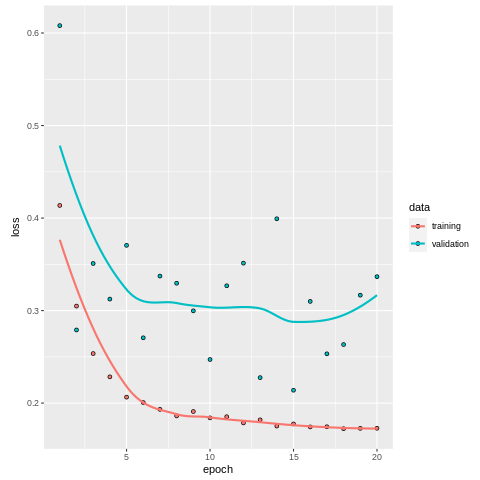

In [17]:
%%R
plot(history)